# Text Classification Model (Keras)

Training a text classification deep learning model using TensorFlow Keras

In [39]:
import csv
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import tensorflow as tf
import models

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

In [40]:
# download pretrained GloVe word vectors

!wget -nc https://github.com/tlkh/shortcuts/releases/download/g0.1/glove.6B.50d.txt -O ./data/glove.6B.50d.txt

File ‘./data/glove.6B.50d.txt’ already there; not retrieving.


In [41]:
# notebook settings

MAX_NB_WORDS = 2**16
MAX_SEQUENCE_LENGTH = 128
VALIDATION_SPLIT = 0.3
EMBEDDING_DIM = 50
GLOVE_DIR = "./data/glove.6B.50d.txt"
MODELS = ["mlp", "cnn", "lstm"]
MODEL_NAME = MODELS[2]

## Loading the data

We read the data from `./data/imdb.csv` and perform some basic preprocessing.

In [42]:
texts, labels = [], [] # empty lists for the sentences and labels

def preprocess_text(input_text):
    return input_text.replace("<br />", " ").strip().lower()

with open("./data/imdb.csv", "r") as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)  # skip the headers
    for row in reader:
        texts.append(preprocess_text(row[0]))
        if row[1] == "positive":
            labels.append(1)
        elif row[1] == "negative":
            labels.append(0)
        else:
            print("WARN: invalid label")
            
assert len(texts) == len(labels)

In [43]:
print("Sample data:")
print(texts[0], labels[0])

Sample data:
one of the other reviewers has mentioned that after watching just 1 oz episode you'll be hooked. they are right, as this is exactly what happened with me.  the first thing that struck me about oz was its brutality and unflinching scenes of violence, which set in right from the word go. trust me, this is not a show for the faint hearted or timid. this show pulls no punches with regards to drugs, sex or violence. its is hardcore, in the classic use of the word.  it is called oz as that is the nickname given to the oswald maximum security state penitentary. it focuses mainly on emerald city, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. em city is home to many..aryans, muslims, gangstas, latinos, christians, italians, irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.  i would say the main appeal of the show is due to the fact that it goes wh

Next, we need to **tokenize** the data to convert each unique word into a number. This is needed to allow our embedding layer to work.

We save our tokenizer into a pickle file so that we will be able to re-use it any number of times:

* reduce time when re-running the notebook
* allow different models to use the same tokenizer
* allow us to load the tokenizer into another script for inference

In [44]:
try:
    with open('./data/tokenizer.pickle', 'rb') as f:
        tokenizer = pickle.load(f)
        print("Using cached tokenizer")
except Exception as e:
    print(e)
    print("Creating new tokenizer")
    # the maximum number of words to keep, based on word frequency
    # Only the most common `num_words-1` words will be kept.
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(texts)
    with open('./data/tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print("Saved word tokenizer to file: ./cache/tokenizer.pickle")

Using cached tokenizer


In [45]:
# create the array of inputs
sequences = tokenizer.texts_to_sequences(texts)

# we will need to standardize the lengths of the input arrays
data = tf.keras.preprocessing.sequence.pad_sequences(sequences,
                                                     padding='post',
                                                     maxlen=MAX_SEQUENCE_LENGTH)

In [46]:
# convert the category label to one-hot encoding
labels = tf.keras.utils.to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

x_train, x_val, y_train, y_val = train_test_split(data, labels,
                                                  test_size=VALIDATION_SPLIT)

print('Number of entries in each category:')
print("Training:", y_train.sum(axis=0))
print("Validation:", y_val.sum(axis=0))

Shape of data tensor: (50000, 128)
Shape of label tensor: (50000, 2)
Number of entries in each category:
Training: [17477. 17523.]
Validation: [7523. 7477.]


Inspecting the training data

In [47]:
print("Tokenized sequence:\n", data[0])
print("")
print("One-hot label:\n", labels[0])

Tokenized sequence:
 [   78   275   588  3023   833   179  1319  4160    14  2522  1242   833
  1442   833   886  3183   148   953   182     1    85   397     9   122
   209  3240    67    13    33  1636     8    12  2238     9   412   130
     9    12  1591    14     8    17    13     9   286    50     9  1417
     3  1279    14  3183     2   188 10167     5     1   298  2045     4
  2149   569    20    38   569    17  7657  7153  5009 13496    25  2982
    40    14     3 25421  6903 13496   503    19   641     2    75   242
    15     8    68  7597   650   709  6903   108   661    81  1207 19394
   692     5    64   574     4   919  2020    37  1207   558   146  3183
    21   199   425  3818    15    47     6  3313   804  1602    42    21
    66    75     7  1227    15   124  4102   485]

One-hot label:
 [0. 1.]


## Building the model

Loading the pretrained word vectors

In [48]:
embeddings_index = {}
f = open(GLOVE_DIR)
print("(long) Loading GloVe from:",GLOVE_DIR,"...")
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Building Embedding Matrix...")
embedding_matrix = np.random.random((MAX_NB_WORDS, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if i < MAX_NB_WORDS:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
print("Completed!")

(long) Loading GloVe from: ./data/glove.6B.50d.txt ...
Building Embedding Matrix...
Completed!


Create and compile the model for training

In [49]:
if MODEL_NAME == "mlp":
    model = models.get_mlp(units=128, num_layers=3, max_seq_len=MAX_SEQUENCE_LENGTH, embedding_matrix=embedding_matrix)
elif MODEL_NAME == "cnn":
    model = models.get_cnn(units=128, num_layers=3, max_seq_len=MAX_SEQUENCE_LENGTH, embedding_matrix=embedding_matrix)
elif MODEL_NAME == "lstm":
    model = models.get_lstm(units=128, num_layers=1, bidirectional=True, max_seq_len=MAX_SEQUENCE_LENGTH, embedding_matrix=embedding_matrix)

In [50]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01, decay=1e-4)
opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

lossfn = tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.0)
acc = tf.keras.metrics.CategoricalAccuracy()

model.compile(loss=lossfn,
              optimizer=opt,
              metrics=[acc])

Visualize the model

In [51]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 128, 50)           3276800   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               183296    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 514       
Total params: 3,460,610
Trainable params: 3,460,610
Non-trainable params: 0
_________________________________________________________________


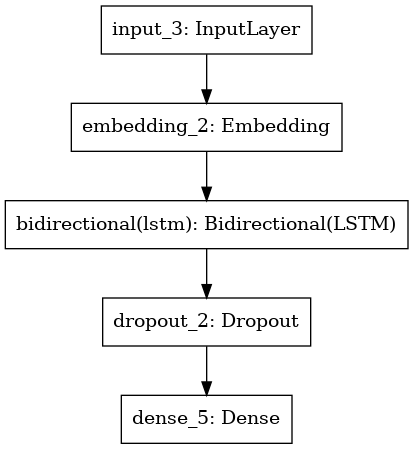

In [52]:
tf.keras.utils.plot_model(model, to_file='./data/'+MODEL_NAME+'.png', show_shapes=False, show_layer_names=True)

## Train the model

In [53]:
# we save checkpoints so that the model can be loaded
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("./data/best_"+MODEL_NAME+".h5",
                                                      monitor='val_categorical_accuracy',
                                                      verbose=1,
                                                      save_best_only=True,
                                                      save_weights_only=False)

In [54]:
model_log = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                      callbacks=[model_checkpoint],
                      epochs=3, batch_size=128)

Epoch 1/3
274/274 [==============================] - 16s 39ms/step - loss: 0.4468 - categorical_accuracy: 0.7891 - val_loss: 0.2939 - val_categorical_accuracy: 0.8762

Epoch 00001: val_categorical_accuracy improved from -inf to 0.87620, saving model to ./data/best_lstm.h5
Epoch 2/3
274/274 [==============================] - 9s 33ms/step - loss: 0.1771 - categorical_accuracy: 0.9332 - val_loss: 0.3121 - val_categorical_accuracy: 0.8801

Epoch 00002: val_categorical_accuracy improved from 0.87620 to 0.88013, saving model to ./data/best_lstm.h5
Epoch 3/3
274/274 [==============================] - 9s 33ms/step - loss: 0.0541 - categorical_accuracy: 0.9830 - val_loss: 0.4033 - val_categorical_accuracy: 0.8656

Epoch 00003: val_categorical_accuracy did not improve from 0.88013


Visualize performance

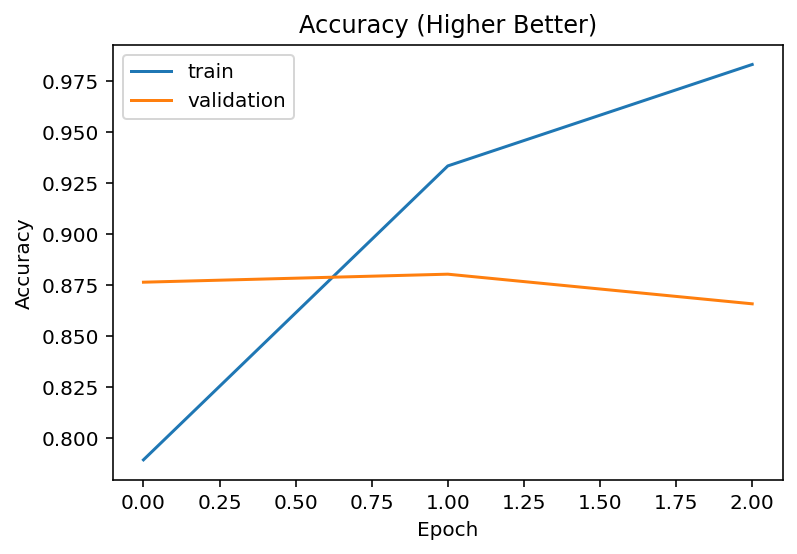

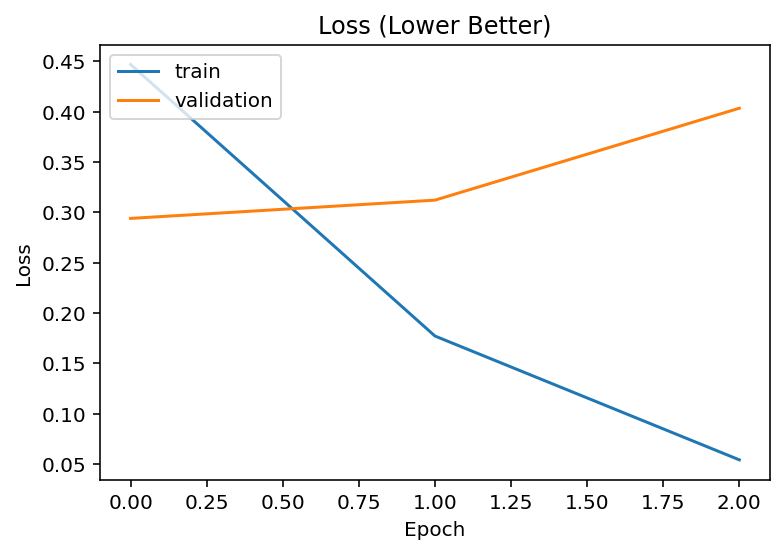

In [55]:
plt.plot(model_log.history['categorical_accuracy'])
plt.plot(model_log.history['val_categorical_accuracy'])
plt.title('Accuracy (Higher Better)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(model_log.history['loss'])
plt.plot(model_log.history['val_loss'])
plt.title('Loss (Lower Better)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()